In [1]:
# ==================
# IMPORT LIBRARIES
# ==================

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("whitegrid")
import plotly.express as px
import plotly.io as pio 
import plotly.graph_objects as go 
import math 
import numpy as np
import pandas as pd
import os
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error , mean_absolute_error 

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import arima 

import warnings
warnings.filterwarnings('ignore') # Ignore warning
pd.set_option('display.max_columns', None) # Display any number of columns

In [2]:
parse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')

# Read the CSV file with date parsing
df = pd.read_csv(
    "../Dataset/Stocks/ibm.us.txt",
    sep=',',
    index_col="Date",
    parse_dates=["Date"],
    date_parser=parse
).fillna(0)

df

Open      High       Low     Close   Volume  OpenInt
Date                                                                
1962-01-02    6.4130    6.4130    6.3378    6.3378   467056        0
1962-01-03    6.3378    6.3963    6.3378    6.3963   350294        0
1962-01-04    6.3963    6.3963    6.3295    6.3295   314365        0
1962-01-05    6.3211    6.3211    6.1958    6.2041   440112        0
1962-01-08    6.2041    6.2041    6.0373    6.0870   655676        0
...              ...       ...       ...       ...      ...      ...
2017-11-06  150.2700  150.3200  148.7900  149.3500  4543499        0
2017-11-07  149.8700  150.0100  149.0100  149.8500  3729501        0
2017-11-08  150.1000  150.2800  148.7900  150.0700  4679520        0
2017-11-09  149.9300  151.8000  149.8600  150.3000  4776388        0
2017-11-10  150.6500  150.8900  149.1400  149.1600  4306433        0

[14059 rows x 6 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14059 entries, 1962-01-02 to 2017-11-10
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     14059 non-null  float64
 1   High     14059 non-null  float64
 2   Low      14059 non-null  float64
 3   Close    14059 non-null  float64
 4   Volume   14059 non-null  int64  
 5   OpenInt  14059 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 768.9 KB


In [4]:
# Create traces for Open and Close prices
trace_open = go.Scatter(x=df.index, y=df['Open'], mode='lines', name='Open Price')
trace_close = go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Close Price')

# Layout settings
layout = go.Layout(
    title='Opening & Closing Price of Market',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    legend=dict(x=0, y=1.0),
    margin=dict(l=80, r=80, t=40, b=40),
    height=500,
    width=1100,
)

# Combine the traces and layout
fig = go.Figure(data=[trace_open, trace_close], layout=layout)

# Display the plot
pio.show(fig)

<Axes: ylabel='Density'>

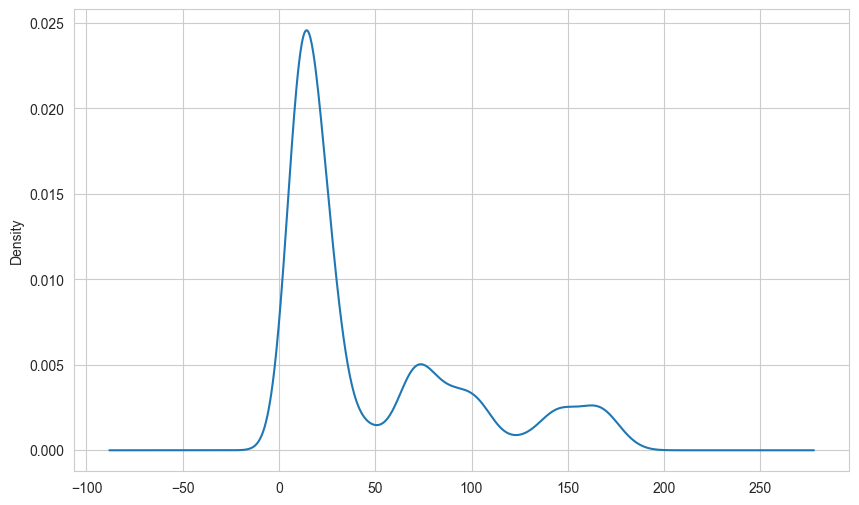

In [5]:
df["Close"].plot(kind='kde')

In [6]:
# Function to test for stationarity in a time series
def test_stationarity(timeseries):
    """
    This function takes a time series data as input and performs the following:
    1. Computes rolling statistics (mean and standard deviation) over a window of 12 months.
    2. Plots the original time series along with its rolling mean and standard deviation using Plotly.
    3. Conducts the Augmented Dickey-Fuller (ADF) test to statistically check for stationarity.

    Parameters:
    timeseries (pd.Series): Time series data to be analyzed.

    Returns:
    None: Outputs plots and test results.
    """
    
    # Step 1: Calculate rolling mean and standard deviation with a window size of 12 (monthly basis for yearly data)
    # Rolling Mean (Moving Average) helps smooth the data by averaging values over a specified window, helping to identify trends.
    # Rolling Standard Deviation helps visualize how the data's variability changes over time.
    rolling_mean = timeseries.rolling(window=12).mean()  # Calculate 12-month rolling mean
    rolling_std = timeseries.rolling(window=12).std()    # Calculate 12-month rolling standard deviation

    # Step 2: Plot original time series and its rolling statistics using Plotly to visually inspect stationarity
    # Plotly allows for interactive plots, which can be more useful for in-depth analysis.
    fig = go.Figure()

    # Adding the original time series to the plot
    fig.add_trace(go.Scatter(x=timeseries.index, y=timeseries, mode='lines', name='Original', line=dict(color='blue')))
    
    # Adding the rolling mean to the plot
    fig.add_trace(go.Scatter(x=rolling_mean.index, y=rolling_mean, mode='lines', name='Rolling Mean', line=dict(color='red')))
    
    # Adding the rolling standard deviation to the plot
    fig.add_trace(go.Scatter(x=rolling_std.index, y=rolling_std, mode='lines', name='Rolling Std Dev', line=dict(color='black')))
    
    # Update the layout of the plot
    fig.update_layout(title='Rolling Mean and Standard Deviation',
                      xaxis_title='Date',
                      yaxis_title='Value',
                      legend=dict(x=0, y=1),
                      height=600,
                      width=1200)
    
    # Show the plot
    fig.show()

    # Step 3: Perform the Augmented Dickey-Fuller test to statistically check for stationarity
    # The ADF test helps determine if a time series is stationary by testing the null hypothesis:
    # Null Hypothesis: The time series is non-stationary (has a unit root).
    # If the test statistic is less than the critical value, we reject the null hypothesis (indicating stationarity).
    print("Results of Augmented Dickey-Fuller Test:")
    adf_test = adfuller(timeseries, autolag='AIC')  # Perform ADF test with automatic lag selection based on AIC criterion
    
    # Step 4: Display ADF test results in a more interpretable format
    # Create a pandas Series to display key results of the ADF test
    # 'Test Statistic' tells us the ADF statistic for the series.
    # 'p-value' indicates the probability of observing the data under the null hypothesis. A low p-value (<0.05) indicates stationarity.
    # 'No. of Lags Used' shows the number of lagged differences used in the test.
    # 'Number of Observations Used' gives the sample size after adjusting for lags.
    results = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', 'No. of Lags Used', 'Number of Observations Used'])

    # Add critical values for different significance levels to the output
    # 'critical values' indicate the threshold values for rejecting the null hypothesis at different confidence levels (1%, 5%, 10%).
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    # Print the test results
    print(results)

# Example usage with some time series data, e.g., 'df_close'
test_stationarity(df["Close"])

Results of Augmented Dickey-Fuller Test:
Test Statistic                    -0.268885
p-value                            0.929797
No. of Lags Used                  42.000000
Number of Observations Used    14016.000000
Critical Value (1%)               -3.430817
Critical Value (5%)               -2.861746
Critical Value (10%)              -2.566880
dtype: float64


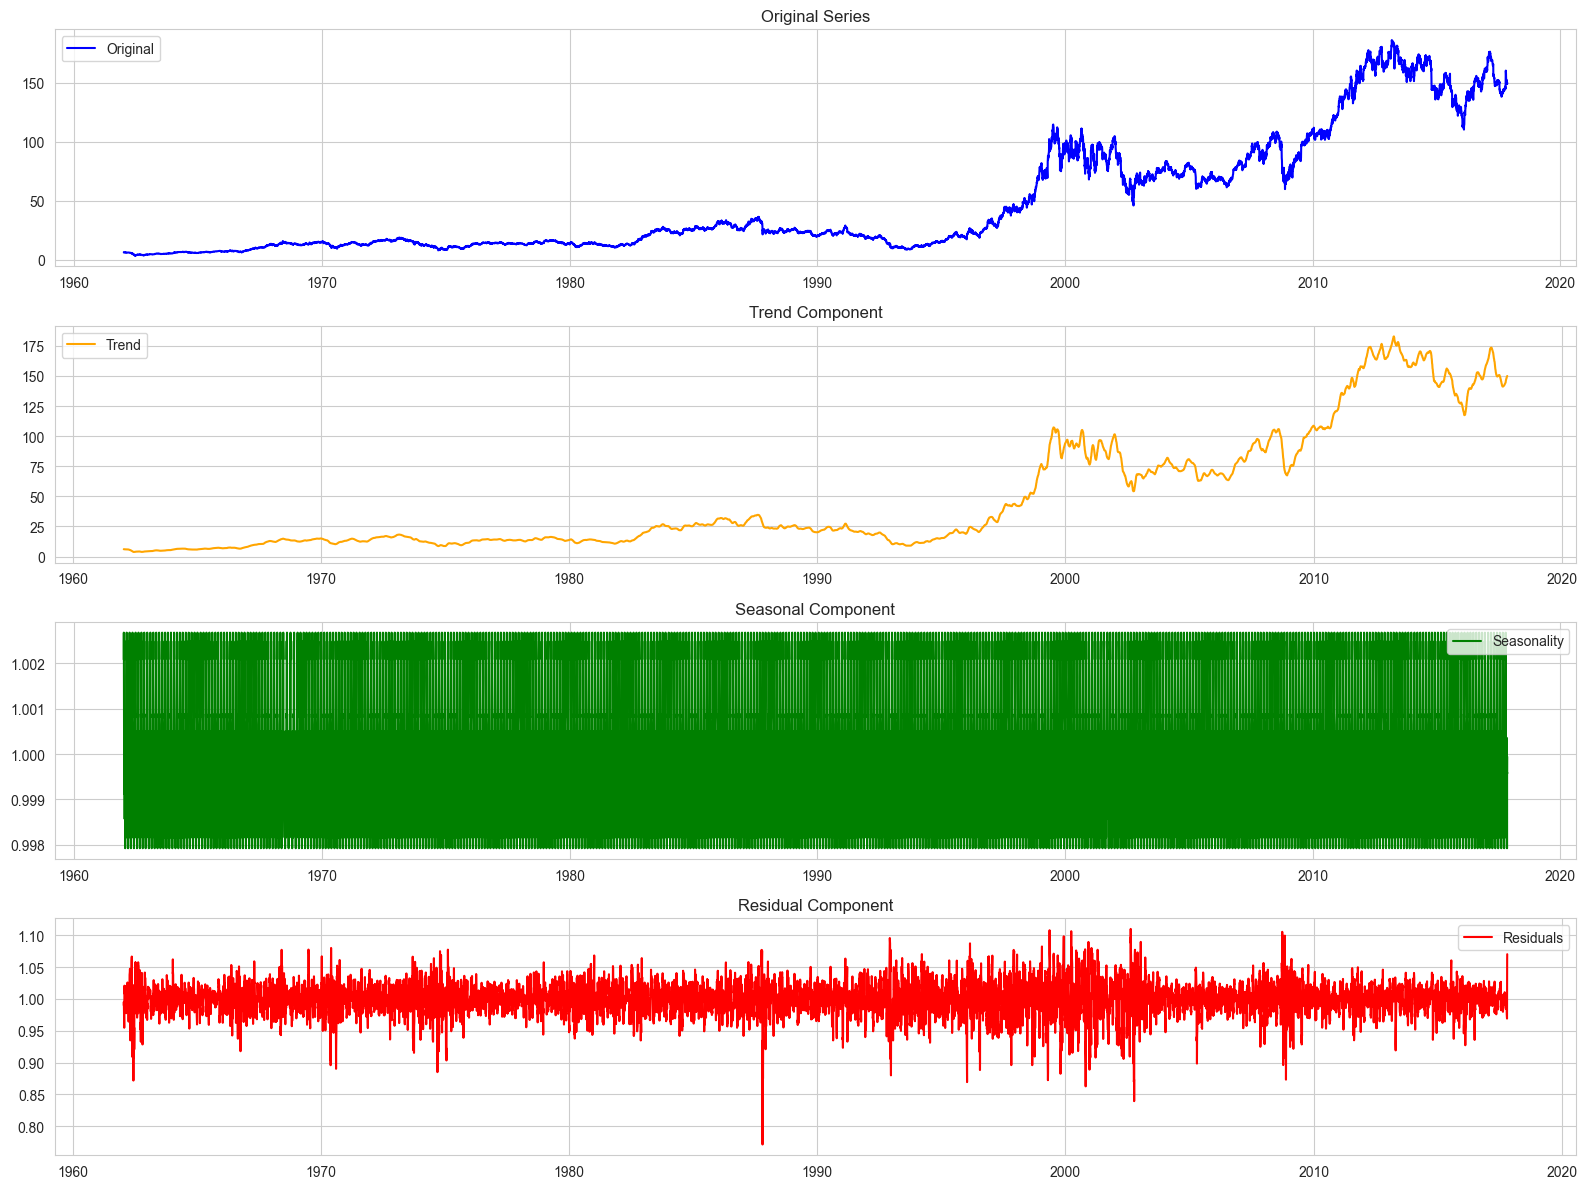

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Decompose the series using the multiplicative model
result = seasonal_decompose(df["Close"], model='multiplicative', period=30)

# Create subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 12))  # Set figure size and subplots

# Plot Original Series
ax1.plot(df["Close"], label='Original', color='blue')
ax1.set_title('Original Series')
ax1.legend(loc='best')

# Plot Trend Component
ax2.plot(result.trend, label='Trend', color='orange')
ax2.set_title('Trend Component')
ax2.legend(loc='best')

# Plot Seasonal Component
ax3.plot(result.seasonal, label='Seasonality', color='green')
ax3.set_title('Seasonal Component')
ax3.legend(loc='best')

# Plot Residual Component
ax4.plot(result.resid, label='Residuals', color='red')
ax4.set_title('Residual Component')
ax4.legend(loc='best')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

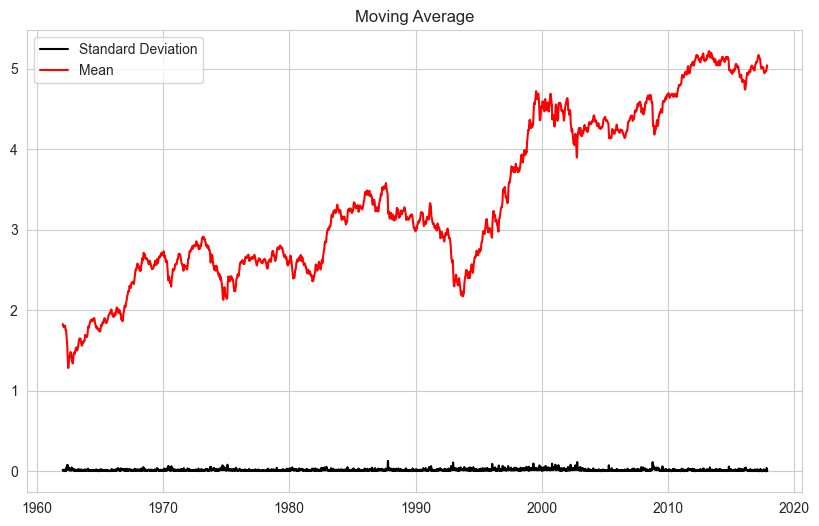

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df["Close"])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()
